In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor as RFR

# XGBoost package
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Martin\anaconda3\envs\ydata-profiling_compatible\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Martin\anaconda3\envs\ydata-profiling_compatible\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\Martin\anaconda3\envs\ydata-profiling_compatible\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv('Spanish Housing/spanish_houses.csv')
df

,ad_description,ad_last_update,air_conditioner,balcony,bath_num,built_in_wardrobe,chimney,condition,construct_date,energetic_certif,...,room_num,storage_room,swimming_pool,terrace,unfurnished,number_of_companies_prov,population_prov,companies_prov_vs_national_%,population_prov_vs_national_%,renta_media_prov
0,Precio chalet individual en la localidad de Ab...,Anuncio actualizado el 27 de marzo,0,0,2,0,0,segunda mano/buen estado,NaN,NaN,...,4,0,0,1,NaN,19147,328868,0.57,0.70,19889.0
1,"Atico de 80m2, para entrar a vivir, con salón ...",más de 5 meses sin actualizar,0,0,2,0,0,segunda mano/buen estado,2006.0,no indicado,...,3,1,0,0,NaN,19147,328868,0.57,0.70,19889.0
2,B/ Etxaguen. Casa de reciente construcción con...,más de 5 meses sin actualizar,0,0,3,0,0,segunda mano/buen estado,NaN,no indicado,...,4,1,0,1,NaN,19147,328868,0.57,0.70,19889.0
3,Se vende vivienda en abornikano (ayuntamiento ...,más de 5 meses sin actualizar,0,1,1,1,1,segunda mano/buen estado,NaN,en trámite,...,4,1,0,1,NaN,19147,328868,0.57,0.70,19889.0
4,Negociables.,más de 5 meses sin actualizar,0,0,1,0,0,segunda mano/buen estado,NaN,no indicado,...,2,1,1,1,NaN,19147,328868,0.57,0.70,19889.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,casa de pueblo con patio.,Anuncio actualizado el 29 de enero,0,0,1,0,0,segunda mano/para reformar,NaN,no indicado,...,3,0,0,0,NaN,11632,174549,0.35,0.37,NaN
99996,"Superf. 2299 m², 1090 m² solar, 10 habitacione...",Anuncio actualizado el 27 de septiembre,0,0,2,0,0,NaN,1908,no indicado,...,10,0,0,0,NaN,11632,174549,0.35,0.37,NaN
99997,ad_description,ad_last_update,air_conditioner,balcony,bath_num,built_in_wardrobe,chimney,condition,construct_date,energetic_certif,...,room_num,storage_room,swimming_pool,terrace,unfurnished,11632,174549,0.35,0.37,NaN
99998,Inmueble de 89 m² ubicado en ZAMORA (Zamora).,Anuncio actualizado el 10 de abril,0,0,2,0,0,NaN,NaN,no indicado,...,3,0,0,0,NaN,11632,174549,0.35,0.37,NaN


In [3]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
df.info()

# As we can see the dataset is very dirty, most column types are object while some should just be int64 or float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ad_description                 95426 non-null   object 
 1   ad_last_update                 100000 non-null  object 
 2   air_conditioner                100000 non-null  object 
 3   balcony                        100000 non-null  object 
 4   bath_num                       100000 non-null  object 
 5   built_in_wardrobe              100000 non-null  object 
 6   chimney                        100000 non-null  object 
 7   condition                      86059 non-null   object 
 8   construct_date                 32059 non-null   object 
 9   energetic_certif               74691 non-null   object 
 10  floor                          79693 non-null   object 
 11  garage                         40811 non-null   object 
 12  garden                         

In [4]:
### DATA CLEANING ###

In [5]:
# We are dropping all columns linked with description as we are not doing sentiment analysis here
# We are also dropping columns which are not intrinsecally linked with the property in itself
# We are also dropping every column linked with location except loc_city, from which we're going to data scrap other infos
# We are also dropping columns like renta_media_prow as we are going to try to data scrap them by ourselves
# We are also dropping heating floor, garage, orientation and chimney columns since it will be too hard to deal with
# I also make the choice to only keep m2_real as the surface variable

df.drop(columns=["obtention_date", "orientation", "chimney", "house_id","m2_useful", "loc_district","loc_city", "loc_full","loc_neigh", "loc_street", "loc_zone", "ad_description","ad_last_update","number_of_companies_prov","population_prov","companies_prov_vs_national_%","population_prov_vs_national_%","renta_media_prov", "floor", "garage", "heating"],axis=1, inplace=True)

In [6]:
# Let's focus on all the columns that should only contain numerical values (booleans, continous and some categorical data) :
# I'm referring to the data set documentation : 
num_col = ["air_conditioner", "balcony", "bath_num", "built_in_wardrobe", "construct_date", "garden", "ground_size", "lift", "kitchen", "m2_real","price", "reduced_mobility", "room_num", "storage_room", "swimming_pool", "terrace"]
for col in num_col:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [7]:
df["kitchen"].sample(50)

86361   NaN
63845   NaN
12727   NaN
20047   NaN
79428   NaN
64719   NaN
19728   NaN
15095   NaN
61608   NaN
16792   NaN
70955   NaN
42314   NaN
33281   NaN
86901   NaN
5956    NaN
45400   NaN
90706   NaN
2663    NaN
79803   NaN
33098   NaN
26675   NaN
41087   NaN
76131   NaN
9902    NaN
97732   NaN
58480   NaN
19879   NaN
58399   NaN
81879   NaN
64309   NaN
57775   NaN
66188   NaN
83205   NaN
74930   NaN
83582   NaN
27366   NaN
47306   NaN
51238   NaN
80736   NaN
51978   NaN
9402    NaN
4641    NaN
18046   NaN
32433   NaN
66592   NaN
5231    NaN
57007   NaN
40156   NaN
40265   NaN
99739   NaN
Name: kitchen, dtype: float64

In [8]:
# Let's first deal with boolean variables

In [9]:
# Get the number of unique values of "unfurnished"
print("count of nan : ", len(df.loc[(df["unfurnished"].isnull()),"unfurnished"]))

# We will then assume that missing values can be replaced by 0, this assumption might be changed later
df["unfurnished"] = df["unfurnished"].fillna(0)

# Same, we will assume that the string unfurnished stands for 0
mask = (df["unfurnished"] == "unfurnished")
df.loc[mask,"unfurnished"] = 0

# Let's finally put everything to int
df["unfurnished"] = df[["unfurnished"]].astype(float).astype(int)

df["unfurnished"].sum()
# We have finally cleaned our "unfurnished" column

count of nan :  99354


463

In [10]:
# Same job with kitchen

# Get the number of unique values of "kitchen"
print("count of nan : ", len(df.loc[(df["kitchen"].isnull()),"kitchen"]))

# We will then assume that missing values can be replaced by 0, this assumption might be changed later
df["kitchen"] = df["kitchen"].fillna(0)

# Same, we will assume that the string kitchen stands for 0
mask = (df["kitchen"] == "kitchen")
df.loc[mask,"kitchen"] = 0

# Let's finally put everything to int
df["kitchen"] = df[["kitchen"]].astype(float).astype(int)

df["kitchen"].sum()

# We have finally cleaned our "kitchen" column

count of nan :  97971


2029

In [11]:
# Same job with lift

# Get the number of unique values of "unfurnished"
print("count of nan : ", len(df.loc[(df["lift"].isnull()),"lift"]))

# We will then assume that missing values can be replaced by 0, this assumption might be changed later
df["lift"] = df["lift"].fillna(0)

# Same, we will assume that the string lift stands for 0
mask = (df["lift"] == "lift")
df.loc[mask,"lift"] = 1

# Let's finally put everything to int
df["lift"] = df[["lift"]].astype(float).astype(int)

df["lift"].sum()

# We have finally cleaned our "lift" column

count of nan :  41218


38543

In [12]:
# Now let's clean other variables 

In [13]:
# Ground_size variable 

df["ground_size"].unique().tolist()

# We see that this variable is empty, so we get rid of it: 

df.drop("ground_size", axis = 1, inplace = True)

In [14]:
# Let's focus on construction date
print("the different data types in the columns :", df["construct_date"].apply(type).unique().tolist())
df["construct_date"] = pd.to_numeric(df["construct_date"], errors='coerce')
df["construct_date"] = df["construct_date"].fillna(0)
df["construct_date"] = df["construct_date"].apply(int)
df["construct_date"].unique().tolist()

# Let's see the number of missing values 

print("number of missing values : ",(df["construct_date"]==0).sum())

# Given that it is a categorical variable with a lot of missing values, and which is fundamental to understand the price of the house, we decide to drop all the observation with missing values 

row_mask = df["construct_date"] == 0
df = df.loc[~row_mask]

print("number of observations left :", len(df))

# We're left with 31 876 observation, which is still enough to train some models
# It is a categorical data, with very high cardinality, we decide to group by decade

dates = df["construct_date"]

df["construct_date"] = (df["construct_date"]//10)*10

the different data types in the columns : [<class 'float'>]
number of missing values :  68124
number of observations left : 31876


In [15]:
# Let's now focus on the energy certification
print("The different unique values contained in the variable are :", df["energetic_certif"].unique().tolist())

# We're going to group 'en trámite', 'inmueble exento' and consider "no indicado" and missing values as not insulated
row_mask_insulate = ((df["energetic_certif"] == 'en trámite') | (df["energetic_certif"] == 'inmueble exento'))
df["energetic_certif"].loc[row_mask_insulate] = "insulated"

# We're going to group "no indicado" and missing values by "not insulated" :
row_mask = df["energetic_certif"] != "insulated"
df["energetic_certif"].loc[~row_mask_insulate] = "not insulated"

# We have cleaned the energy certification feature

The different unique values contained in the variable are : ['no indicado', 'en trámite', nan, 'inmueble exento']


The different unique values contained in the house condition variable are : ['segunda mano/buen estado', 'segunda mano/para reformar', 'promoción de obra nueva', nan]


<Axes: >

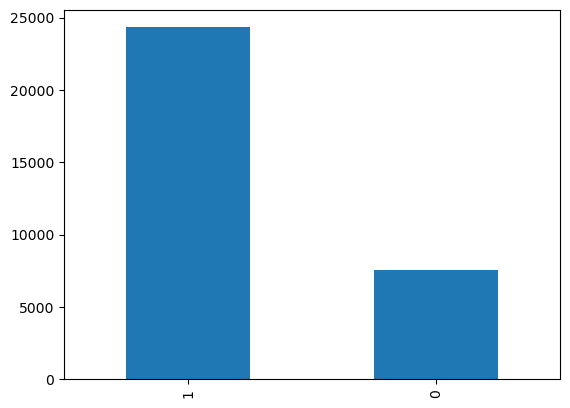

In [16]:
# Let's now focus on the house's condition
print("The different unique values contained in the house condition variable are :", df["condition"].unique().tolist())

# Let's replace the missing values by 0 for now : 
df["condition"] = df["condition"].fillna(0)

# In order to simplify things and not to have to much imbalance between the categorical variables, we're going to 
# Change the variable to a boolean one, with value True if equal to 'segunda mano/buen estado' and 0 else
row_mask_True = df['condition'] == 'segunda mano/buen estado'

df["condition"].loc[row_mask_True] = df['condition'].loc[row_mask_True] = 1

row_mask_False = df['condition'] != 1

df.loc[row_mask_False,"condition"] = df.loc[row_mask_False,'condition'] = 0

df['condition'].value_counts().plot(kind='bar')

In [17]:
# To replace missing values for the next variables we're going to use a new method :
#Replacing using k-nearest neighbors imputer

import pandas as pd
from sklearn.impute import KNNImputer

# Specify the column you want to impute

# Make a copy of the original DataFrame to preserve the original
df_imputed = df.select_dtypes(include=['number']).copy()


# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5).set_output(transform="pandas")  # You can adjust the number of neighbors

# Fit and transform the data using KNN imputer for the selected column
imputed_df = imputer.fit_transform(df_imputed)

imputed_df["bath_num"]

1        2.0
21       3.0
39       2.0
40       2.0
61       1.0
        ... 
99988    1.0
99989    1.0
99990    1.0
99996    2.0
99999    1.0
Name: bath_num, Length: 31876, dtype: float64

The different unique values contained in the df variable are : [2.0, 3.0, 1.0, 6.0, 4.0, 5.0, 8.0, 10.0, 15.0, 9.0, 1.2, 1.4, 2.2, 11.0, 14.0, 7.0, 13.0, 12.0, 1.6, 2.6, 16.0, 5.2, 3.6, 1.8, 20.0, 2.8, 3.8, 4.2, 2.4, 3.4, 5.4, 17.0, 75.0]


<Axes: >

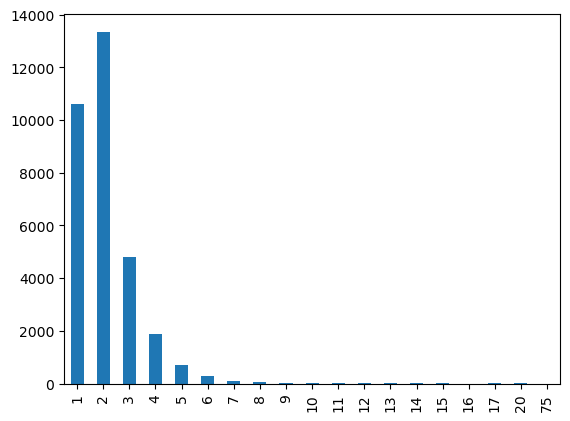

In [18]:
# Let's now focus on the number of bathrooms

df["bath_num"] = imputed_df["bath_num"]

print("The different unique values contained in the df variable are :", df["bath_num"].unique().tolist())


# This methods return a mean value of the nearests neighbors, that's why we have to round the column

df["bath_num"] = df["bath_num"].apply(round).apply(int)

df['bath_num'].value_counts().sort_index().plot(kind='bar')

<Axes: >

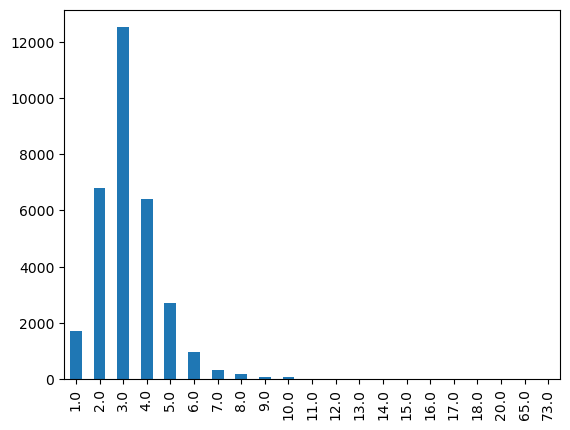

In [19]:
# Let's now focus on the number of rooms

df["room_num"] = imputed_df["room_num"]


# This methods return a mean value of the nearests neighbors, that's why we have to round the column
df["room_num"] = df["room_num"].apply(round).apply(int)
df["room_num"] = df["room_num"].apply(float)

df['room_num'].value_counts().sort_index().plot(kind='bar')

['Ático', ' Casa o chalet independiente', ' Casa o chalet', ' Casa rural', 'Piso', ' Chalet adosado', 'Estudio', ' Finca rústica', ' Casa de pueblo', 'Dúplex', ' Chalet pareado', ' Caserón', ' Torre', ' Cortijo', 'Casa rural', ' Masía', ' Casa terrera', ' Palacio', ' Castillo']


<Axes: >

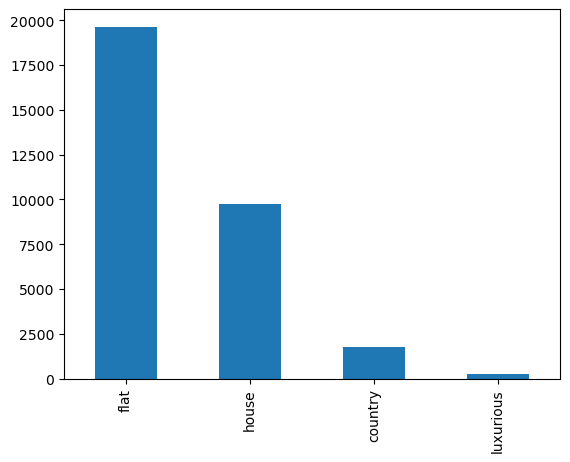

In [20]:
# Now let's focus on the house_type variable

#df['house_type'].value_counts().sort_index().plot(kind='bar')

# We see that some observation have the word "Alquiler" in it, which we don't want since we're studying house price not rents

row_mask = df["house_type"].apply(lambda str: "alquiler" in str.lower())
df = df.loc[~row_mask]

print(df["house_type"].unique().tolist())

# We are going to reduce cardinality by regrouping the different values in 4 main types :
dic = {"house" : [' Casa o chalet independiente',' Casa o chalet', ' Chalet adosado', ' Chalet pareado'], "flat": ['Ático', 'Piso', 'Dúplex'], "luxurious" : ['Estudio',' Caserón', ' Torre', ' Palacio', ' Castillo'], "country" : [' Casa rural',' Finca rústica', ' Casa de pueblo', ' Cortijo', 'Casa rural', ' Masía', ' Casa terrera'] }

row_mask_house = df["house_type"].apply(lambda str: str in dic["house"])
row_mask_flat = df["house_type"].apply(lambda str: str in dic["flat"])
row_mask_luxurious = df["house_type"].apply(lambda str: str in dic["luxurious"])
row_mask_country = df["house_type"].apply(lambda str: str in dic["country"])

df["house_type"].loc[row_mask_house] = "house"
df["house_type"].loc[row_mask_flat] = "flat"
df["house_type"].loc[row_mask_luxurious] = "luxurious"
df["house_type"].loc[row_mask_country] = "country"

df['house_type'].value_counts().plot(kind='bar')

In [21]:
### All the variables are finally cleaned

# Now let's check if some variables are unbalanced

In [22]:
#sns.catplot(data=df, x='kitchen', kind='count')
#sns.catplot(data=df, x='unfurnished', kind='count')

# We see that these two variables are highly unbalanced

# One way could be to drop them but we'll first try to do something else :

# Let's see if we can group them to mitigate this effect : 
# We are going to create a boolean column furnished which will take 1 if it has a kitchen or is furnished and 0 otherwise

row_mask_True = ((df['kitchen'] == 1) | (df['unfurnished'] == 0))
row_mask_False = ~row_mask_True
row_mask_False.sum()

# But we see that no house meets the conditions, so we just decide to drop those two columns
df.drop(["kitchen",'unfurnished'], axis=1, inplace = True)
df

,air_conditioner,balcony,bath_num,built_in_wardrobe,condition,construct_date,energetic_certif,garden,house_type,lift,m2_real,price,reduced_mobility,room_num,storage_room,swimming_pool,terrace
1,0.0,0.0,2,0.0,1,2000,not insulated,0.0,flat,1,86.0,139000.0,1.0,3.0,1.0,0.0,0.0
21,0.0,1.0,3,1.0,1,1990,not insulated,1.0,house,0,700.0,360000.0,0.0,4.0,1.0,0.0,0.0
39,0.0,0.0,2,0.0,1,1980,insulated,1.0,house,0,260.0,355000.0,0.0,4.0,1.0,0.0,1.0
40,0.0,0.0,2,0.0,1,2000,not insulated,1.0,house,0,121.0,168300.0,0.0,3.0,1.0,0.0,0.0
61,0.0,0.0,1,0.0,0,1890,insulated,0.0,country,0,17500.0,120000.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99988,0.0,0.0,1,0.0,1,1970,not insulated,0.0,flat,0,94.0,36000.0,0.0,3.0,0.0,0.0,1.0
99989,0.0,0.0,1,0.0,1,1950,not insulated,0.0,country,0,39.0,69000.0,0.0,4.0,0.0,0.0,0.0
99990,0.0,0.0,1,0.0,1,1930,not insulated,0.0,country,0,93.0,78000.0,0.0,3.0,0.0,0.0,0.0
99996,0.0,0.0,2,0.0,0,1900,not insulated,1.0,house,0,460.0,119000.0,0.0,10.0,0.0,0.0,0.0


In [23]:
### Now that the data set is finally ready for training let's prepare it for training

In [24]:
df_hot = df.copy()

var_onehot = ["energetic_certif","house_type"]

df_hot = pd.get_dummies(df_hot, columns=['energetic_certif'])
df_hot = pd.get_dummies(df_hot, columns=["house_type"])

print(df_hot)

       air_conditioner  balcony  bath_num  built_in_wardrobe condition  \
1                  0.0      0.0         2                0.0         1   
21                 0.0      1.0         3                1.0         1   
39                 0.0      0.0         2                0.0         1   
40                 0.0      0.0         2                0.0         1   
61                 0.0      0.0         1                0.0         0   
...                ...      ...       ...                ...       ...   
99988              0.0      0.0         1                0.0         1   
99989              0.0      0.0         1                0.0         1   
99990              0.0      0.0         1                0.0         1   
99996              0.0      0.0         2                0.0         0   
99999              0.0      0.0         1                0.0         0   

       construct_date  garden  lift  m2_real     price  ...  room_num  \
1                2000     0.0     1   

In [25]:
df_hot.drop("energetic_certif_not insulated", axis=1)

,air_conditioner,balcony,bath_num,built_in_wardrobe,condition,construct_date,garden,lift,m2_real,price,reduced_mobility,room_num,storage_room,swimming_pool,terrace,energetic_certif_insulated,house_type_country,house_type_flat,house_type_house,house_type_luxurious
1,0.0,0.0,2,0.0,1,2000,0.0,1,86.0,139000.0,1.0,3.0,1.0,0.0,0.0,0,0,1,0,0
21,0.0,1.0,3,1.0,1,1990,1.0,0,700.0,360000.0,0.0,4.0,1.0,0.0,0.0,0,0,0,1,0
39,0.0,0.0,2,0.0,1,1980,1.0,0,260.0,355000.0,0.0,4.0,1.0,0.0,1.0,1,0,0,1,0
40,0.0,0.0,2,0.0,1,2000,1.0,0,121.0,168300.0,0.0,3.0,1.0,0.0,0.0,0,0,0,1,0
61,0.0,0.0,1,0.0,0,1890,0.0,0,17500.0,120000.0,0.0,2.0,0.0,0.0,0.0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99988,0.0,0.0,1,0.0,1,1970,0.0,0,94.0,36000.0,0.0,3.0,0.0,0.0,1.0,0,0,1,0,0
99989,0.0,0.0,1,0.0,1,1950,0.0,0,39.0,69000.0,0.0,4.0,0.0,0.0,0.0,0,1,0,0,0
99990,0.0,0.0,1,0.0,1,1930,0.0,0,93.0,78000.0,0.0,3.0,0.0,0.0,0.0,0,1,0,0,0
99996,0.0,0.0,2,0.0,0,1900,1.0,0,460.0,119000.0,0.0,10.0,0.0,0.0,0.0,0,0,0,1,0


In [26]:
df_hot.drop("house_type_country",axis=1)

,air_conditioner,balcony,bath_num,built_in_wardrobe,condition,construct_date,garden,lift,m2_real,price,reduced_mobility,room_num,storage_room,swimming_pool,terrace,energetic_certif_insulated,energetic_certif_not insulated,house_type_flat,house_type_house,house_type_luxurious
1,0.0,0.0,2,0.0,1,2000,0.0,1,86.0,139000.0,1.0,3.0,1.0,0.0,0.0,0,1,1,0,0
21,0.0,1.0,3,1.0,1,1990,1.0,0,700.0,360000.0,0.0,4.0,1.0,0.0,0.0,0,1,0,1,0
39,0.0,0.0,2,0.0,1,1980,1.0,0,260.0,355000.0,0.0,4.0,1.0,0.0,1.0,1,0,0,1,0
40,0.0,0.0,2,0.0,1,2000,1.0,0,121.0,168300.0,0.0,3.0,1.0,0.0,0.0,0,1,0,1,0
61,0.0,0.0,1,0.0,0,1890,0.0,0,17500.0,120000.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99988,0.0,0.0,1,0.0,1,1970,0.0,0,94.0,36000.0,0.0,3.0,0.0,0.0,1.0,0,1,1,0,0
99989,0.0,0.0,1,0.0,1,1950,0.0,0,39.0,69000.0,0.0,4.0,0.0,0.0,0.0,0,1,0,0,0
99990,0.0,0.0,1,0.0,1,1930,0.0,0,93.0,78000.0,0.0,3.0,0.0,0.0,0.0,0,1,0,0,0
99996,0.0,0.0,2,0.0,0,1900,1.0,0,460.0,119000.0,0.0,10.0,0.0,0.0,0.0,0,1,0,1,0


In [27]:
df_hot["construct_date"]=dates

In [28]:
# StandardScaler: makes sure that all 4 variables have a zero mean and a unit variance
# MinMaxScaler: makes sure that all 4 variables lie in [0,1]
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [29]:
df_hot[["m2_real"]] = StandardScaler().fit_transform(df_hot[["m2_real"]])
df_hot[["construct_date"]] = MinMaxScaler().fit_transform(df_hot[["construct_date"]])
df_hot

,air_conditioner,balcony,bath_num,built_in_wardrobe,condition,construct_date,garden,lift,m2_real,price,...,room_num,storage_room,swimming_pool,terrace,energetic_certif_insulated,energetic_certif_not insulated,house_type_country,house_type_flat,house_type_house,house_type_luxurious
1,0.0,0.0,2,0.0,1,0.036872,0.0,1,-0.091089,139000.0,...,3.0,1.0,0.0,0.0,0,1,0,1,0,0
21,0.0,1.0,3,1.0,1,0.035908,1.0,0,-0.056907,360000.0,...,4.0,1.0,0.0,0.0,0,1,0,0,1,0
39,0.0,0.0,2,0.0,1,0.033980,1.0,0,-0.081402,355000.0,...,4.0,1.0,0.0,1.0,1,0,0,0,1,0
40,0.0,0.0,2,0.0,1,0.036751,1.0,0,-0.089141,168300.0,...,3.0,1.0,0.0,0.0,0,1,0,0,1,0
61,0.0,0.0,1,0.0,0,0.022894,0.0,0,0.878389,120000.0,...,2.0,0.0,0.0,0.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99988,0.0,0.0,1,0.0,1,0.033498,0.0,0,-0.090644,36000.0,...,3.0,0.0,0.0,1.0,0,1,0,1,0,0
99989,0.0,0.0,1,0.0,1,0.031088,0.0,0,-0.093706,69000.0,...,4.0,0.0,0.0,0.0,0,1,1,0,0,0
99990,0.0,0.0,1,0.0,1,0.028678,0.0,0,-0.090700,78000.0,...,3.0,0.0,0.0,0.0,0,1,1,0,0,0
99996,0.0,0.0,2,0.0,0,0.025063,1.0,0,-0.070268,119000.0,...,10.0,0.0,0.0,0.0,0,1,0,0,1,0


<function matplotlib.pyplot.show(close=None, block=None)>

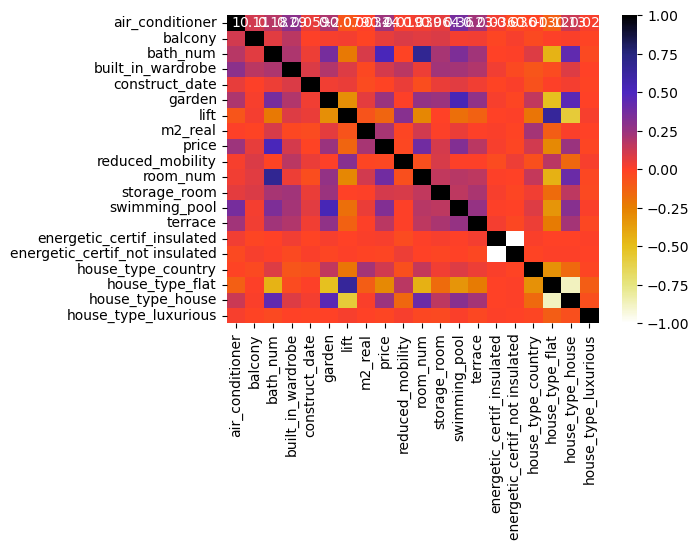

In [30]:
plt.figure(figsize=(6,4))
cor = df_hot.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show

In [31]:
Y = df_hot["price"]
X = df_hot.drop("price", axis = 1)

Y = Y.astype(int)
X = X.fillna(0)
Y = Y.fillna(0)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
# Split test set and train set

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
Xtrain

,air_conditioner,balcony,bath_num,built_in_wardrobe,condition,construct_date,garden,lift,m2_real,reduced_mobility,room_num,storage_room,swimming_pool,terrace,energetic_certif_insulated,energetic_certif_not insulated,house_type_country,house_type_flat,house_type_house,house_type_luxurious
74968,0.0,1.0,2,1.0,1,0.036992,1.0,1,-0.087749,1.0,3.0,1.0,1.0,0.0,0,1,0,1,0,0
28483,1.0,1.0,15,0.0,1,0.022894,1.0,0,-0.046941,0.0,15.0,1.0,1.0,1.0,0,1,0,0,1,0
71845,0.0,1.0,1,0.0,1,0.032896,0.0,1,-0.091591,0.0,3.0,0.0,0.0,0.0,1,0,0,1,0,0
93260,0.0,0.0,2,1.0,1,0.035787,0.0,0,-0.080567,0.0,4.0,1.0,0.0,0.0,0,1,0,0,1,0
93497,1.0,1.0,2,1.0,1,0.037474,0.0,1,-0.088083,1.0,3.0,0.0,0.0,0.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23961,0.0,0.0,4,1.0,1,0.038197,1.0,0,-0.029070,0.0,5.0,1.0,1.0,1.0,1,0,0,0,1,0
15020,1.0,0.0,2,1.0,1,0.037113,1.0,1,-0.090421,0.0,2.0,0.0,1.0,1.0,1,0,0,1,0,0
93301,1.0,0.0,1,0.0,1,0.034703,0.0,0,-0.080289,0.0,4.0,0.0,0.0,1.0,0,1,0,0,1,0
8470,0.0,0.0,1,0.0,1,0.033137,0.0,0,0.101481,0.0,3.0,0.0,0.0,0.0,1,0,0,0,1,0


In [34]:
Xtest

,air_conditioner,balcony,bath_num,built_in_wardrobe,condition,construct_date,garden,lift,m2_real,reduced_mobility,room_num,storage_room,swimming_pool,terrace,energetic_certif_insulated,energetic_certif_not insulated,house_type_country,house_type_flat,house_type_house,house_type_luxurious
40873,0.0,0.0,2,1.0,1,0.036149,0.0,1,-0.089197,0.0,3.0,0.0,0.0,1.0,1,0,0,1,0,0
31544,0.0,1.0,2,0.0,0,0.022894,1.0,0,-0.086246,0.0,3.0,0.0,0.0,1.0,0,1,1,0,0,0
88217,0.0,0.0,2,1.0,1,0.033739,0.0,1,-0.087471,1.0,4.0,0.0,0.0,0.0,0,1,0,1,0,0
2765,1.0,0.0,1,0.0,0,0.030124,0.0,0,-0.093038,0.0,2.0,0.0,0.0,0.0,0,1,0,1,0,0
30402,1.0,1.0,3,1.0,1,0.033739,1.0,0,-0.067540,0.0,4.0,0.0,1.0,1.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37849,0.0,0.0,4,1.0,1,0.035305,1.0,0,-0.062474,0.0,4.0,0.0,0.0,0.0,1,0,0,0,1,0
35794,0.0,1.0,2,0.0,0,0.033860,0.0,1,-0.088696,0.0,4.0,1.0,0.0,1.0,1,0,0,1,0,0
22173,1.0,1.0,8,0.0,1,0.024099,0.0,0,-0.044158,0.0,7.0,1.0,0.0,1.0,0,1,0,0,1,0
96920,0.0,0.0,2,1.0,1,0.034944,1.0,0,0.739208,1.0,2.0,0.0,1.0,1.0,0,1,0,0,1,0


In [35]:
Ytrain

74968     460000
28483    2500000
71845     162000
93260     299000
93497     206000
          ...   
23961    1280000
15020     404100
93301     278000
8470       80000
18867     235000
Name: price, Length: 25128, dtype: int32

In [36]:
Ytest

40873     405000
31544     275000
88217     375000
2765       21500
30402    1850000
          ...   
37849     585000
35794     124000
22173     900000
96920     325000
45291     150000
Name: price, Length: 6283, dtype: int32

In [37]:
Ypred = KNNR(n_neighbors=5).fit(Xtrain,Ytrain).predict(Xtest)

In [38]:
# Evaluate the XgBoost model
model_xgb = xgb.XGBRegressor().fit(Xtrain,Ytrain)
pred_xgb = model_xgb.predict(Xtest)

In [39]:
# Based on the picture, we redefine our plotting function,
# which incorporates this time a numeric performance measure:
def plot_pred(yobs,ypred):
  plt.figure(figsize=(4.5,4.5))
  sns.scatterplot(x=yobs, y=ypred)
  plt.xlabel('Observed values')
  plt.ylabel('Predicted values')
  plt.title('MAE =' + str(round(abs(yobs-ypred).mean(),2)))
  plt.plot([0,10000000],[0,10000000],'r')
  plt.show()

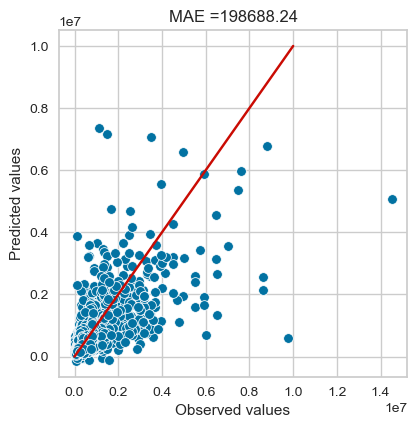

In [137]:
plot_pred(Ytest,pred_xgb)

In [74]:
# Evaluate the K-Nearest Neighbors regressor

RMSE_KNN = -cross_val_score(KNNR(n_neighbors=50), X, Y, cv=5, scoring='neg_root_mean_squared_error').mean()
RMSE_KNN

482337.4510744132

In [75]:
# Evaluate the random tree forest regressor

RMSE_KNN = -cross_val_score(KNNR(n_neighbors=50), X, Y, cv=5, scoring='neg_root_mean_squared_error').mean()
RMSE_KNN

482337.4510744132

In [ ]:
# Create a price predictor given the different features : 

def house_prediction():
    dict = {}
    for feature in Xtrain.columns.tolist():
        dict[feature] = input(f"Does your house has this {feature} :")
    return dict

feature_vector = pd.Series(house_prediction())
feature_vector = pd.to_numeric(feature_vector, errors="coerce")
print('features of the movie :', feature_vector)

price_prediction = model_xgb.predict(feature_vector)
print("this is your predicted price :", price_prediction)  

In [76]:
# check installed version (must be >3.0)
import pycaret
pycaret.__version__

'3.2.0'

In [77]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(df_hot, target = 'price', session_id = 123, max_encoding_ohe=0)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(31411, 21)"
4,Transformed data shape,"(31411, 21)"
5,Transformed train set shape,"(21987, 21)"
6,Transformed test set shape,"(9424, 21)"
7,Ordinal features,1
8,Numeric features,19
9,Categorical features,1


In [78]:
# compare baseline models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,189918.1015,190008151838.4274,433144.6256,0.5372,0.5761,0.5944,0.9220
lightgbm,Light Gradient Boosting Machine,195661.0486,193859922072.7955,437058.6419,0.5300,0.5939,0.6245,0.1270
gbr,Gradient Boosting Regressor,198607.2663,195292926707.0721,438334.4738,0.5272,0.6024,0.6465,0.2430
et,Extra Trees Regressor,198471.0220,220198549305.9372,466892.2639,0.4616,0.5988,0.6099,0.7610
knn,K Neighbors Regressor,218546.3875,254007825203.2000,500867.0906,0.3823,0.6362,0.6405,0.0860
ridge,Ridge Regression,247857.7591,277402819081.4954,518717.1876,0.3418,0.8736,0.8610,0.0260
lasso,Lasso Regression,247782.0186,277451282412.9390,518768.6439,0.3417,0.8711,0.8609,0.6800
lr,Linear Regression,247899.8764,277602473820.4932,518875.1043,0.3414,0.8743,0.8617,1.1170
llar,Lasso Least Angle Regression,247687.6613,277564867883.7785,518863.8100,0.3414,0.8849,0.8591,0.0260
br,Bayesian Ridge,247998.5254,277587235455.6988,518891.6199,0.3413,0.8754,0.8607,0.0300


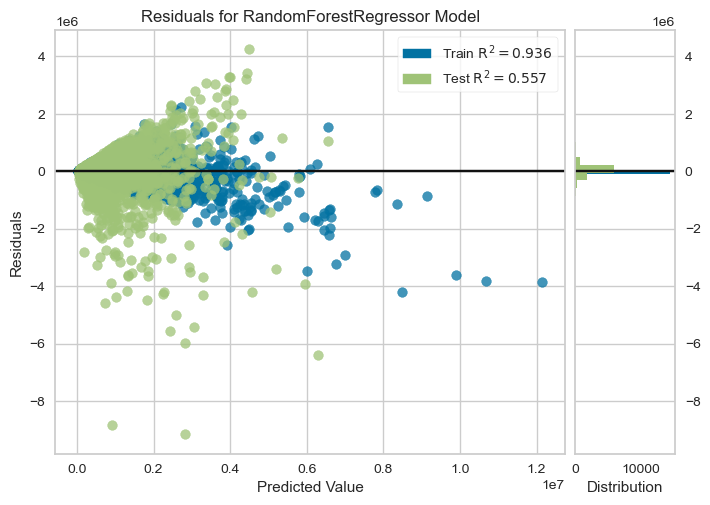

In [79]:
# plot residuals
plot_model(best, plot = 'residuals')

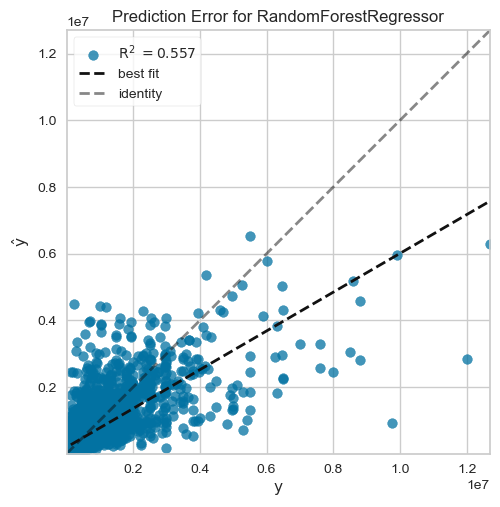

In [80]:
# plot error
plot_model(best, plot = 'error')